## Team UnicorNN - Challenge 2 (Photovoltaic Generation)

Team Members:
- Sofia Sibanic
- Jordan Pratt
- Bijoy George
- Adrian Goldberg
- Michael Fraser
- Sandesh Satpute

<b> Changelog </b>

| Revised by | Changes made | Rev | Date |
|------------|--------------|-----|------|
| S.S | Uploaded to git | 0 | 7 Oct 18 |
| S.S | Revised significantly. Consider this the new 'base' version | 1 | 14 Oct 18 |
| S.S | Visualising data for user understanding. | 1A | 14 Oct 18 |
| S.S | Corrected notebook significantly as it was not saving properly in Mozilla Firefox | 1B | 14 Oct 18 |
| S.S | Gained insights from data on how installations are changing, and parameters to consider. | 1C | 16 Oct 18 |
| S.S | Finished data insights section, pushed to git. | 1D | 16 Oct 18 |
| S.S | Tidying of the notebook and some modifications to the way train/valid set are set up | 1E | 20 Oct 18 |

Issues:
- Autosaving and manual saving are not working in Mozilla FireFox 62.0.3 (x64)

## Part A - Rooftop Solar Panel Detection

### Module Importing, Variable Definitions and Path Links

In [165]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For the import to work, a symbolic link must be made relative to this notebook. The link should be to the old/fastai folder containing the modules noted below.

Example:
- Notebook is in ~/teamunicornn/challenge_2/notebooks
- Modules are in a folder called ~/old/fastai
- Module folder is in ~/teamunicornn/challenge_2/
- Relative path to the modules from the notebook then is ../../old/fastai

To create the symlink, open Anaconda Prompt and enter mklink /d fastai_hackagig ../../old/fastai

In [166]:
# Import external libraries
from fastai_hackagig.imports import *
# Import fast.ai libraries
from fastai_hackagig.transforms import *
from fastai_hackagig.conv_learner import *
from fastai_hackagig.model import *
from fastai_hackagig.dataset import *
from fastai_hackagig.sgdr import *
from fastai_hackagig.plots import *

In [214]:
# Import additional libraries
import datetime as dt
import random as rdm
from random import shuffle
import distutils
from distutils import dir_util

from matplotlib import pyplot as plt
from PIL import Image
from shutil import copy, move, rmtree

In [168]:
# Define relative path from notebook to the solar PV data (release_clean and release_extra)
PATH = "../../../data/pvdata/"
# File analysis resolution
sz=299

### Verify GPU (CUDA and CUDNN) Initialisation

In [169]:
if torch.cuda.is_available():
    print('GPU is CUDA capable and ready.')
else: print('GPU needs to be CUDA capable and available.')

if torch.backends.cudnn.enabled:
    print('CUDNN is available.')
else: print('CUDNN is not available. This may impact image processing time.')

GPU is CUDA capable and ready.
CUDNN is available.


### Data Verification

In [170]:
def getImageRes(imgFullPath):
    img  = Image.open(imgFullPath)
    resX, resY = img.size
    return resX, resY

In [171]:
def getDateFromNumbers(installDate_unprocessed,preferredFormat='%d,%m,%Y'):
    dd = int(installDate_unprocessed[0:2])
    mm = int(installDate_unprocessed[2:4])
    yyyy = int(installDate_unprocessed[4:8])
    date_OriginalFormat = dt.date(year=yyyy,month=mm,day=dd)
    return date_OriginalFormat.strftime(preferredFormat).split(',')

def getParamsFromFileName(fileName,HasPV=True):
    if HasPV:
        listInstallationInfo = (fileName.split('_')[0]).split(' ')
        listInstallationInfo = list(filter(None, listInstallationInfo))
        print(listInstallationInfo)

        id, sizeWatts, EST_panelCount, installDate = listInstallationInfo
        installDate = getDateFromNumbers(installDate)
        installDay,installMonth,installYear = installDate
    else:
        id = fileName.split('_')[0]
        sizeWatts,EST_panelCount,installDay,installMonth,installYear = [0,0,0,0,0]
    
    cropped = True if 'cropped' in fileName.lower() else False
    imgLarge = True if 'large' in fileName.lower() else False
    
    return [id,int(sizeWatts)/1000,int(EST_panelCount),int(installDay),int(installMonth),int(installYear),cropped,imgLarge]

In [172]:
os.listdir(PATH)

['models',
 'release_clean',
 'release_extra',
 'tempData',
 'test1',
 'tmp',
 'train',
 'valid']

<b> Check number of files in each directory. </b>

In [173]:
# Original data
cleanPVpath = f'{PATH}release_clean/PV/'
extraPVpath = f'{PATH}release_extra/PV/'
cleanNonPVpath = f'{PATH}release_clean/Not_PV/'
extraNonPVpath = f'{PATH}release_extra/Not_PV/'

# Temporary sorting folder
tmpPath = f'{PATH}tempData/'
tmpPVPath = f'{PATH}tempData/PV/'
tmpNonPVPath = f'{PATH}tempData/NonPV/'

# Training and Validation folders
trainPVpath = f'{PATH}train/PV/'
trainNonPVpath = f'{PATH}train/Not_PV/'
validPVPath = f'{PATH}valid/PV/'
validNonPVpath = f'{PATH}valid/Not_PV/'

cleanPV_tot = len(os.listdir(cleanPVpath))
cleanNonPV_tot = len(os.listdir(f'{PATH}release_clean/Not_PV/'))
extraPV_tot = len(os.listdir(extraPVpath))
extraNonPV_tot = len(os.listdir(f'{PATH}release_extra/Not_PV/'))
PV_tot = cleanPV_tot + extraPV_tot
NonPV_tot = cleanNonPV_tot + extraNonPV_tot
AllImages_min = min(PV_tot,NonPV_tot)

print('Clean Release PV Files: ' + str(cleanPV_tot))
print('Clean Release Non-PV Files: ' + str(cleanNonPV_tot))
print('Extra Release PV Files: ' + str(extraPV_tot))
print('Extra Release Non-PV Files: ' + str(extraNonPV_tot))
print('Images that can be utilised for training: ' + str(AllImages_min))

Clean Release PV Files: 1792
Clean Release Non-PV Files: 2113
Extra Release PV Files: 8158
Extra Release Non-PV Files: 4453
Images that can be utilised for training: 6566


<b>Show to the user some data set information, such as: </b>

- Installations by Month & Year
- Average installation size by year
- Ratio of panels to system size (kW) by year

In [174]:
# Put PV files from each release (clean, extra) into separate string lists
listPVFilesClean = os.listdir(cleanPVpath)
listPVFilesExtra = os.listdir(extraPVpath)

In [175]:
%%capture

# Import metadata from each image into a specific list (clean, extra)
listPVMetadataClean = []
listPVMetadataExtra = []
for fileNameClean in listPVFilesClean:
    resXY = list(getImageRes(cleanPVpath + fileNameClean));
    listPVMetadataClean.append(getParamsFromFileName(fileNameClean) + resXY);

for fileNameExtra in listPVFilesExtra:
    resXY = list(getImageRes(extraPVpath + fileNameExtra));
    listPVMetadataExtra.append(getParamsFromFileName(fileNameExtra) + resXY);

In [176]:
tblColumnHeaders = ['ID','Capacity(kW)','Panels_EST','Istl_DAY','Istl_MTH','Istl_YR','Cropped','Large','DimX','DimY']
df_PVClean = pd.DataFrame(listPVMetadataClean,columns=tblColumnHeaders)
df_PVExtra = pd.DataFrame(listPVMetadataExtra,columns=tblColumnHeaders)

In [177]:
df_PVClean[:5]

,ID,Capacity(kW),Panels_EST,Istl_DAY,Istl_MTH,Istl_YR,Cropped,Large,DimX,DimY
0,000001,5.00,28,17,1,2011,True,False,528,528
1,000003,1.80,10,7,6,2011,True,False,426,426
2,000005,2.64,14,19,7,2011,True,False,425,425
3,000006,5.00,28,14,9,2011,True,False,403,403
4,000008,2.66,14,4,8,2011,True,False,492,492


In [178]:
df_PVExtra[:5]

,ID,Capacity(kW),Panels_EST,Istl_DAY,Istl_MTH,Istl_YR,Cropped,Large,DimX,DimY
0,020001,1.11,6,25,1,2012,True,False,466,466
1,020003,5.00,16,24,1,2018,True,False,400,400
2,020005,1.40,8,3,11,2009,True,False,400,400
3,020006,1.90,10,13,4,2011,True,False,400,400
4,020008,3.12,16,16,11,2012,True,False,527,527


<b> Installations by Month </b>

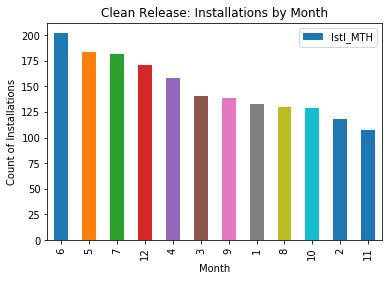

In [179]:
ax1 = pd.value_counts(df_PVClean['Istl_MTH']).plot(kind='bar', title='Clean Release: Installations by Month',legend=True)
ax1.set_xlabel('Month')
ax1.set_ylabel('Count of Installations');

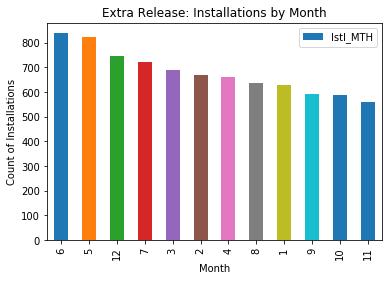

In [180]:
ax2 = pd.value_counts(df_PVExtra['Istl_MTH']).plot(kind='bar', title='Extra Release: Installations by Month',legend=True)
ax2.set_xlabel('Month')
ax2.set_ylabel('Count of Installations');

<b> Installations by Year </b>

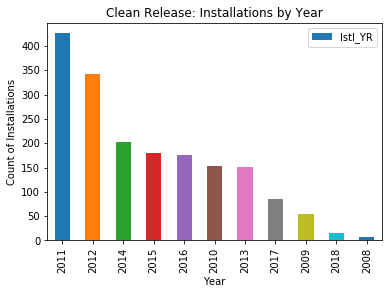

In [181]:
ax3 = pd.value_counts(df_PVClean['Istl_YR']).plot(kind='bar', title='Clean Release: Installations by Year',legend=True)
ax3.set_xlabel('Year')
ax3.set_ylabel('Count of Installations');

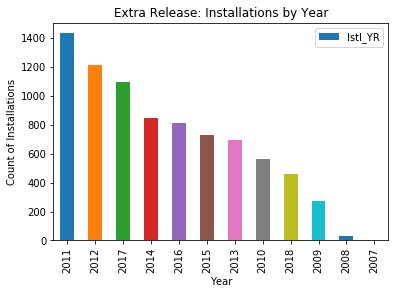

In [182]:
ax4 = pd.value_counts(df_PVExtra['Istl_YR']).plot(kind='bar', title='Extra Release: Installations by Year',legend=True)
ax4.set_xlabel('Year')
ax4.set_ylabel('Count of Installations');

<b> Average Installation Size by Year </b>

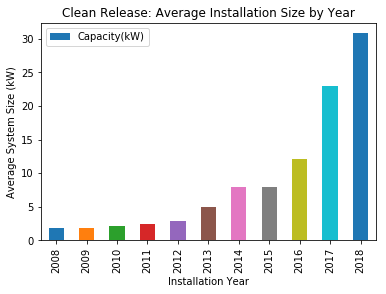

In [183]:
ax5 = df_PVClean.groupby('Istl_YR')['Capacity(kW)'].mean().plot(kind='bar',title='Clean Release: Average Installation Size by Year',legend=True)
ax5.set_xlabel('Installation Year')
ax5.set_ylabel('Average System Size (kW)');

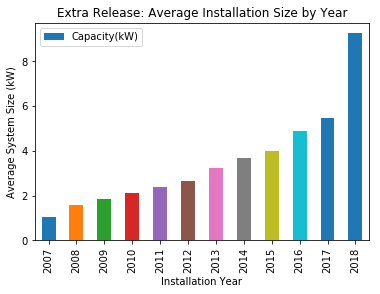

In [184]:
ax6 = df_PVExtra.groupby('Istl_YR')['Capacity(kW)'].mean().plot(kind='bar',title='Extra Release: Average Installation Size by Year',legend=True)
ax6.set_xlabel('Installation Year')
ax6.set_ylabel('Average System Size (kW)');

<b> Ratio of Panels to kiloWatt of System Size by Year </b>

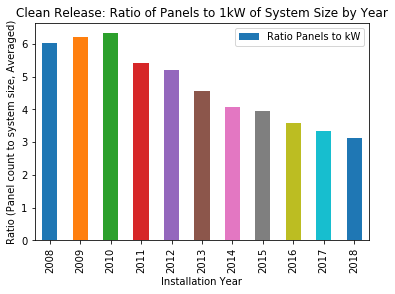

In [185]:
df_PVClean_RatioCalc = df_PVClean
df_PVClean_RatioCalc['Ratio Panels to kW'] = df_PVClean['Panels_EST']/df_PVClean['Capacity(kW)']
ax7 = df_PVClean_RatioCalc.groupby('Istl_YR')['Ratio Panels to kW'].mean().plot(kind='bar',title='Clean Release: Ratio of Panels to 1kW of System Size by Year',legend=True)
ax7.set_xlabel('Installation Year')
ax7.set_ylabel('Ratio (Panel count to system size, Averaged)');

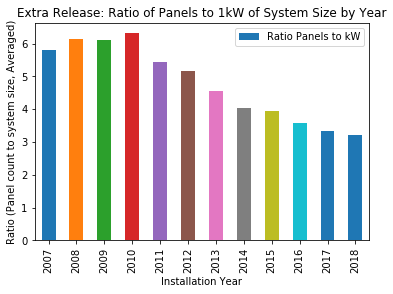

In [186]:
df_PVExtra_RatioCalc = df_PVExtra
df_PVExtra_RatioCalc['Ratio Panels to kW'] = df_PVExtra['Panels_EST']/df_PVExtra['Capacity(kW)']
ax8 = df_PVExtra_RatioCalc.groupby('Istl_YR')['Ratio Panels to kW'].mean().plot(kind='bar',title='Extra Release: Ratio of Panels to 1kW of System Size by Year',legend=True)
ax8.set_xlabel('Installation Year')
ax8.set_ylabel('Ratio (Panel count to system size, Averaged)');

<b> Image Sizes </b>

Clean Dataset - MinX = 400, AvgX = 513.6551339285714, MaxX = 4500


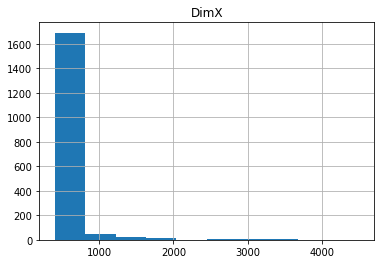

In [187]:
ax9 = df_PVClean.hist(column='DimX')
print('Clean Dataset - MinX = ' + str(df_PVClean['DimX'].min()) + ', AvgX = ' + str(df_PVClean['DimX'].mean()) + ', MaxX = ' + str(df_PVClean['DimX'].max()))

Clean Dataset - MinY = 400, AvgY = 513.0970982142857, MaxY = 4000


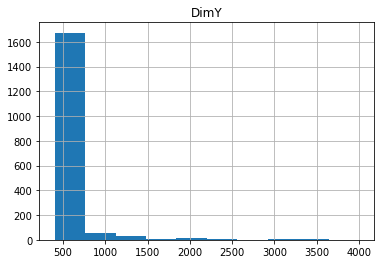

In [188]:
ax10 = df_PVClean.hist(column='DimY')
print('Clean Dataset - MinY = ' + str(df_PVClean['DimY'].min()) + ', AvgY = ' + str(df_PVClean['DimY'].mean()) + ', MaxY = ' + str(df_PVClean['DimY'].max()))

Extra Dataset - MinX = 400, AvgX = 445.37349840647215, MaxX = 6000


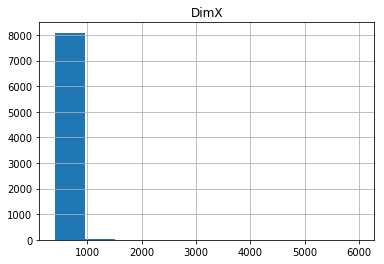

In [189]:
ax11 = df_PVExtra.hist(column='DimX')
print('Extra Dataset - MinX = ' + str(df_PVExtra['DimX'].min()) + ', AvgX = ' + str(df_PVExtra['DimX'].mean()) + ', MaxX = ' + str(df_PVExtra['DimX'].max()))

Extra Dataset - MinY = 400, AvgY = 442.55417994606523, MaxY = 4000


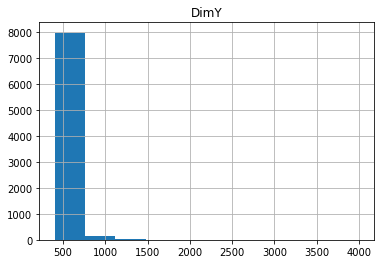

In [190]:
ax12 = df_PVExtra.hist(column='DimY')
print('Extra Dataset - MinY = ' + str(df_PVExtra['DimY'].min()) + ', AvgY = ' + str(df_PVExtra['DimY'].mean()) + ', MaxY = ' + str(df_PVExtra['DimY'].max()))

### Data Insights

| No. | Insight |
|-----|---------|
| 1. | The  majority of the installations in the dataset are from 2011-2012 |
| 2. | The average installation size (kW) appears to be increasing exponentially year-on-year |
| 3. | The number of panels required per 1kW of system size is decreasing year-on-year |
| 4. | The majority of the provided dataset will be approximately 400x400, with some files up to a resolution of 6000px on the x or y axis (or both) |

The model will be developed with the following in mind:
- Panel detection (individual) will become critical in the future as system size continues to increase based on panel efficiency increases.
- The downsampled images need to be mostly compatible with 400x400 resolution imagery, but also be able to accomodate significant size imagery i.e. x by 6000px.

### Prepare Data
Create training set and validation set.

<b> Release Clean: </b>

- Contains the most accurate set of labels for "PV" and "Not_PV".
- PV images in the range 000001 --> 010,000 (1,636 images). <b> Note: different to what the notebook found </b>
- Not PV images in the range 100,001 --> 110,000 (1,992 images) <b> Note: different to what the notebook found </b>

<b> Release Extra: </b>

- Contains examples of larger commercial industrial PV system installations (generally >6kW)
- PV images in the range 010,001 --> 019,999 (156 images) <b> Note: different to what the notebook found </b>
- Not PV images in the range 110,001 --> 119,999 (121 images) <b> Note: different to what the notebook found </b>

In [202]:
# User specifies what percentage of available imagery will be pulled into the training set
pctTotalToTrainSet = 80
# The remaining imagery is placed into the hold-out set 

if os.path.exists(tmpPath):
    # Delete the existing temporary folder
    rmtree(tmpPath, ignore_errors=True)

In [203]:
# Create a fresh temporary folder
os.makedirs(tmpPath)
os.makedirs(tmpPVPath)
os.makedirs(tmpNonPVPath)

In [204]:
%%capture

# Populate temporary folder (aggregate clean and extra release data)
distutils.dir_util.copy_tree(cleanPVpath,tmpPVPath)
distutils.dir_util.copy_tree(extraPVpath,tmpPVPath)
    
distutils.dir_util.copy_tree(cleanNonPVpath,tmpNonPVPath)
distutils.dir_util.copy_tree(extraNonPVpath,tmpNonPVPath)

In [205]:
# Get all imagery file names
listPVFileNames = os.listdir(tmpPVPath)
listNonPVFileNames = os.listdir(tmpNonPVPath)

#print(len(listPVFileNames))
#print(AllImages_min)

# Trim lists down so #PVimages = #NonPVimages
while len(listPVFileNames) > AllImages_min:
    randPV = random.choice(listPVFileNames)
    randPV_index = listPVFileNames.index(randPV)
    #print(randPV)
    #print(listPVFileNames.index(randPV))
    #print(listPVFileNames[listPVFileNames.index(randPV)])
    del listPVFileNames[randPV_index]

# Trim lists down so #PVimages = #NonPVimages
while len(listNonPVFileNames) > AllImages_min:
    randNonPV = random.choice(listNonPVFileNames)
    randNonPV_index = listNonPVFileNames.index(randPV)
    #print(randPV)
    #print(listPVFileNames.index(randPV))
    #print(listPVFileNames[listPVFileNames.index(randPV)])
    del listNonPVFileNames[randNonPV_index]

if len(listPVFileNames) == len(listNonPVFileNames):
    print('Files in temporary folder ready for segmentation into training and validation sets.')
    print('PV files: ' + str(len(listPVFileNames)))
    print('Non PV files: ' + str(len(listNonPVFileNames)))
else:
    print('Imbalance in count of PV and Non PV imagery. This will create issues in training/validation.')

Files in temporary folder ready for segmentation into training and validation sets.
PV files: 6566
Non PV files: 6566


In [206]:
# Select portion to split between training and validation
numTrainingFiles = round((pctTotalToTrainSet/100)*AllImages_min)

#print(numTrainingFiles)
#print(numValidationFiles)

# Randomise selection of files for training and validation set
tmpShufflePVFileNames = listPVFileNames
random.shuffle(tmpShufflePVFileNames)
tmpShuffleNonPVFileNames = listNonPVFileNames
random.shuffle(tmpShuffleNonPVFileNames)

# Split training set file names and validation set file names
listPVFileNames_train = tmpShufflePVFileNames[:numTrainingFiles]
listNonPVFileNames_train = tmpShuffleNonPVFileNames[:numTrainingFiles]

listPVFileNames_valid = tmpShufflePVFileNames[numTrainingFiles:]
listNonPVFileNames_valid = tmpShuffleNonPVFileNames[numTrainingFiles:]

In [207]:
# Ensure that this cell does not return any output, otherwise training/validation sets have overlap
for i in listPVFileNames_train:
    if i in listPVFileNames_valid:
        print('Duplicates exist.')
        break

In [208]:
print('Training set (PV): ' + str(len(listPVFileNames_train)) + ', Training set (Non-PV) : ' + str(len(listNonPVFileNames_train)))
print('Validation set (PV): ' + str(len(listPVFileNames_valid)) + ', Validation set (Non-PV) : ' + str(len(listNonPVFileNames_valid)))

Training set (PV): 5253, Training set (Non-PV) : 5253
Validation set (PV): 1313, Validation set (Non-PV) : 1313


In [209]:
def removeDir(dirPath):
    if os.path.exists(dirPath) and os.path.isdir(dirPath):
        shutil.rmtree(dirPath)
    return

# Delete existing files in training and validation set folders
removeDir(trainPVpath)
removeDir(trainNonPVpath)
removeDir(validPVPath)
removeDir(validNonPVpath)

# Make fresh training and validation set folders
os.mkdir(trainPVpath)
os.mkdir(trainNonPVpath)
os.mkdir(validPVPath)
os.mkdir(validNonPVpath)

In [215]:
def copyImage(listFileNames,tmpPath,nextPath):
    for fileName in listFileNames:
        copy(tmpPath + fileName,nextPath)
    return

# Copy training and validation set files into appropriate folders
copyImage(listPVFileNames_train,tmpPVPath,trainPVpath)
copyImage(listNonPVFileNames_train,tmpNonPVPath,trainNonPVpath)
copyImage(listPVFileNames_valid,tmpPVPath,validPVPath)
copyImage(listNonPVFileNames_valid,tmpNonPVPath,validNonPVpath)

### Model Establishment

| Parameter | Value |
|-----------|-------|
| Type | CNN |
| Architecture | resnet34 |

In [37]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [216]:
# Define architecture
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
noEpochs = 2
lr_rate = 0.01
learn.fit(lr_rate, noEpochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:38<00:00,  1.10it/s]


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.401646   0.332364   0.856816  
    1      0.356689   0.312055   0.864433                                                                              



[array([0.31206]), 0.8644325971058644]

### Analyse results

<b> Check the classification array is binary and properly labelled </b>

In [217]:
# Check classifier is simply looking at PV/NotPV (binary classification)
# data.val_y

# Print to user the name of the classes (e.g. 'Not_PV', 'PV')
data.classes

['Not_PV', 'PV']

In [218]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(PV)

In [219]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [220]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [221]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


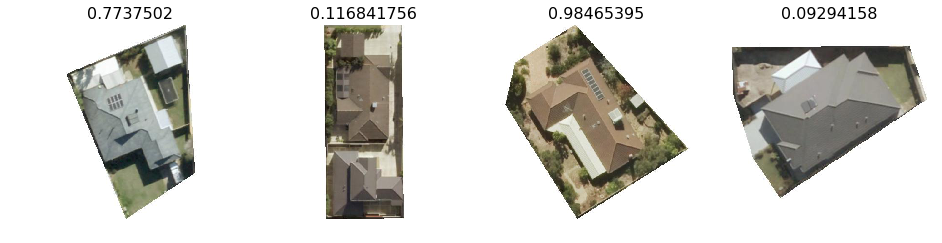

In [222]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


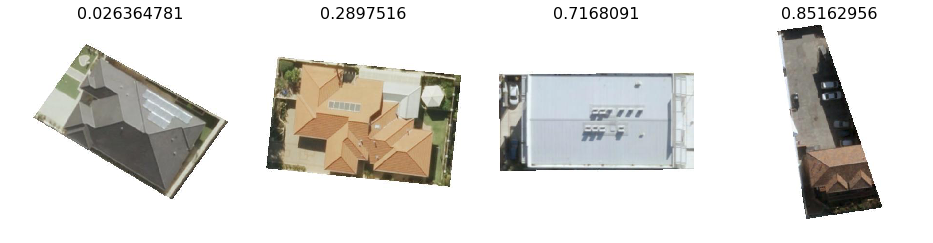

In [223]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [224]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct locations without PV


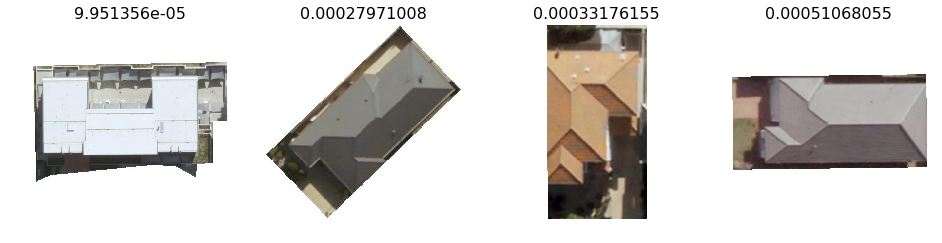

In [225]:
plot_val_with_title(most_by_correct(0, True), "Most correct locations without PV")

Most correct locations with PV


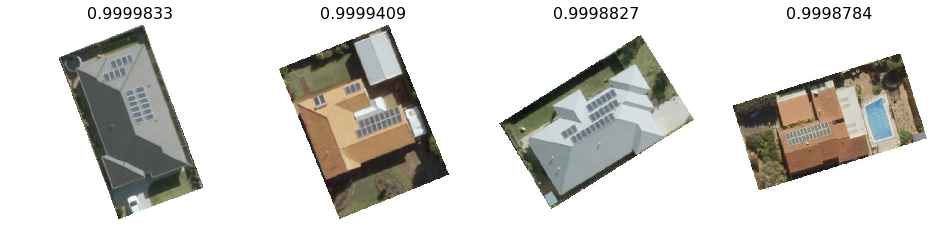

In [226]:
plot_val_with_title(most_by_correct(1, True), "Most correct locations with PV")

Most incorrect locations without PV


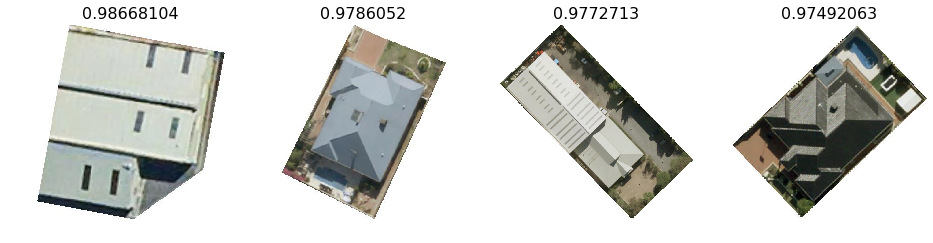

In [227]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect locations without PV")

Most incorrect locations with PV


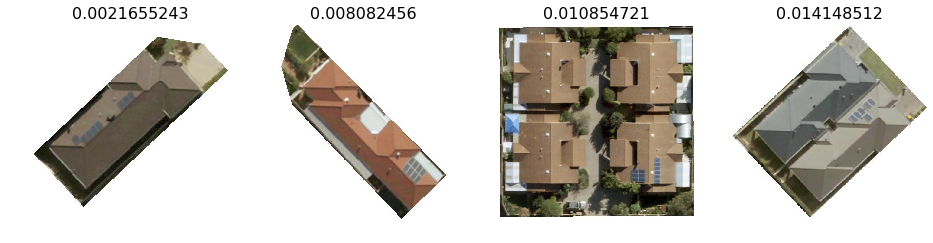

In [228]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect locations with PV")

Most uncertain predictions


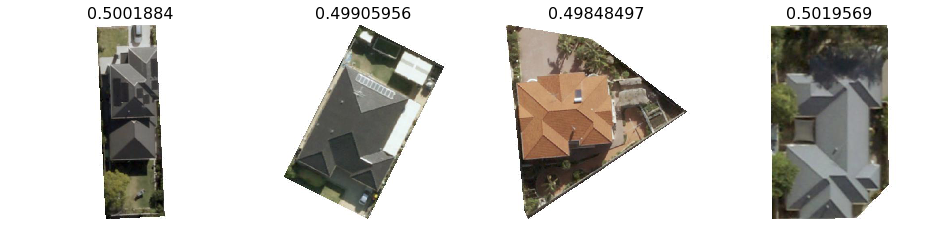

In [229]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Setting the learning rate

Learning rate based on the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186).

In [230]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [231]:
lrf=learn.lr_find()

 81%|████████████████████████████████████████████████████████             | 134/165 [00:01<00:00, 99.65it/s, loss=1.05]


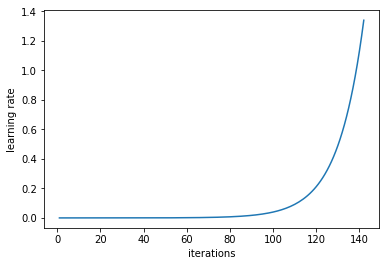

In [232]:
learn.sched.plot_lr()

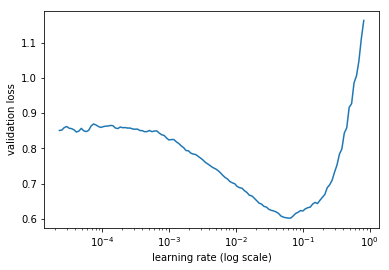

In [233]:
learn.sched.plot()

The learning rate is improving at approximately 1e-2.

### Model Optimisation

<b> Data augmentation </b>

In [234]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [235]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [236]:
ims = np.stack([get_augs() for i in range(6)])

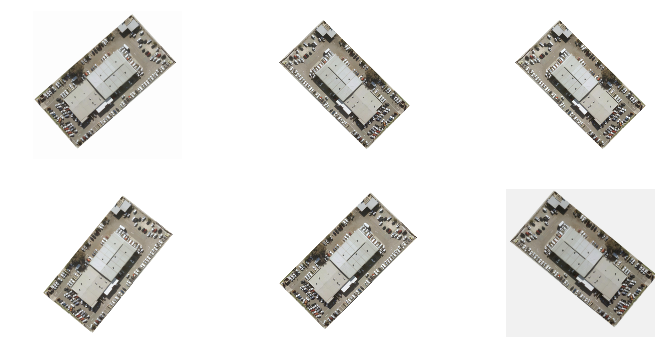

In [237]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [238]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [241]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.328129   0.290987   0.878142  
    1      0.347111   0.284654   0.878142                                                                              
    2      0.312055   0.284735   0.880046                                                                              
    3      0.304872   0.274505   0.884235                                                                              
    4      0.282823   0.280448   0.88195                                                                               



[array([0.28045]), 0.8819497334348819]

In [242]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [243]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.310548   0.274265   0.887281  
    1      0.317369   0.272771   0.885377                                                                              
    2      0.313125   0.270647   0.886139                                                                              



[array([0.27065]), 0.8861386138613861]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

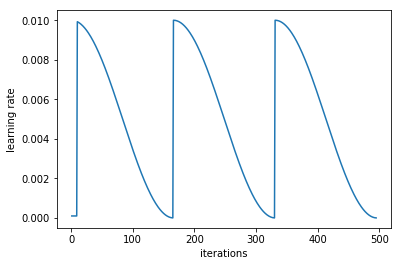

In [244]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [245]:
learn.save('299_lastlayer')

In [246]:
learn.load('299_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [247]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [248]:
lr=np.array([1e-4,1e-3,1e-2])

In [249]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.158863   0.136947   0.947829  
    1      0.120797   0.102825   0.964204                                                                              
    2      0.094689   0.098756   0.964585                                                                              
    3      0.087365   0.095461   0.964585                                                                              
    4      0.072142   0.084595   0.968393                                                                              
    5      0.056653   0.075957   0.97182                                                                               
    6      0.051816   0.075643   0.972963                                                                              



[array([0.07564]), 0.9729626808834729]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

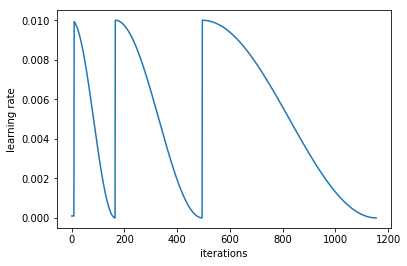

In [250]:
learn.sched.plot_lr()

In [251]:
learn.save('299_all')

In [252]:
learn.load('299_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [253]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [254]:
accuracy_np(probs, y)

0.9779131759329779

## Analyzing results

### Confusion matrix 

In [255]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [256]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[1290   23]
 [  35 1278]]


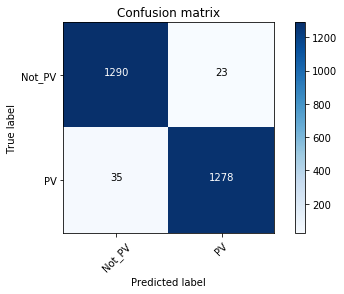

In [257]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect locations without PV


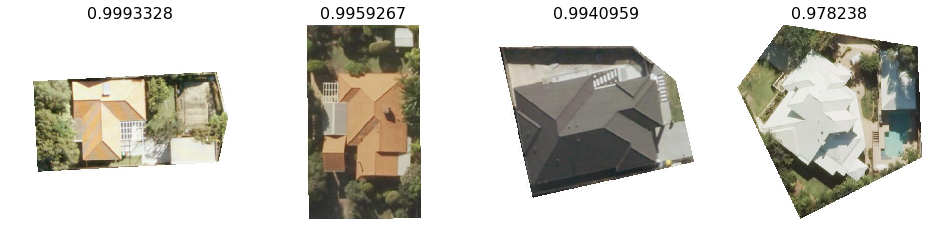

In [258]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect locations without PV")

Most incorrect locations with PV


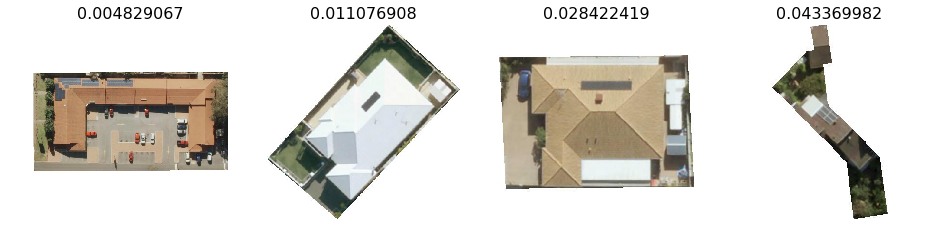

In [259]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect locations with PV")